<a href="https://colab.research.google.com/github/pschorey/Valpo_IT533/blob/main/01_Processing_and_Association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pedagogy Lab 1 (Data Processing and Association)

>You will be working with the [STEAM Games dataset](https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/steam_games.csv) (a cleaned and modified subset of this dataset on [Kaggle](https://www.kaggle.com/datasets/tristan581/all-55000-games-on-steam-november-2022?resource=download&select=steam_games.csv). This is a PARTIAL inventory of the online PC gaming store STEAM. Parts of it were collected on the 8th of November 2022, using the STEAM store API as well as the API of another website, steamspy.com. It contains useful information, such as the products genre, tags, categories, languages and other information.
>
> The features of this dataset are
* AppID: ID of product as allocated by Steam.
* Name: Product name
* Developer: Whoever created the product.
* Publisher: Whoever published the product.
* Genre: The genre(s) that the product is in.
* Categories: The categories/features that the product has.
* Owners: An approximate number of owners, according to Steam Spy.
* Positive_Reviews: The number of positive reviews the product has.
* Negative_Reviews: The number of negativereviews the product has.
* Price_\$: The price of the game in USD.
* Initial_Price_$: The price of the game in USD at launch.
* Discount_%: What percentage sale the product was off by as of 2022/11/8.
* Peak_Concurrent_Players: Peak concurrent players as of 2022/11/8.
* Platforms: What operating systems the product is available on.
* Release Date: When the product was first released.
* Required Age: Whether the user needs to be over a certain age to legally purchase (0 = no restrictions)
* Avg_Rating_5: Average rating from 1 to 5 stars
* Playability_index_10: Average playability index on a scale from 1-10

* Source: Professor Sonja Streuber 2023S1R-IT-533-STEM:Data Mining and Applications

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
from math import acos, degrees
from scipy import spatial
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from sklearn.metrics.pairwise import cosine_similarity
import scipy.spatial.distance as dist #used for Manhattan dist

steam = pd.read_csv("https://raw.githubusercontent.com/pschorey/Valpo_IT533/main/steam_games_short.csv")


# Inspect the data


In [ ]:
steam.head()

,AppID,Name,Developer,Publisher,Genre,Categories,Owners,Positive_Reviews,Negative_Reviews,Price_USD,Initial_Price_USD,Discount_Percent,Peak_Concurrent_Players,Platforms,Release_Date,Required_Age,Avg_Rating_5,Playability_Index_10
0,10,Counter-Strike,Valve,Valve,Action,"Multi-player, Valve Anti-Cheat enabled, Online...","10,000,000 .. 20,000,000",201215,5199,9.99,9.99,0,13990,"windows, mac, linux",11/1/2000,0,3.87,6.54
1,20,Team Fortress Classic,Valve,Valve,Action,"Multi-player, Valve Anti-Cheat enabled, Online...","1,000,000 .. 2,000,000",5835,934,4.99,4.99,0,101,"windows, mac, linux",4/1/1999,0,3.92,8.15
2,30,Day of Defeat,Valve,Valve,Action,"Multi-player, Valve Anti-Cheat enabled","5,000,000 .. 10,000,000",5251,569,4.99,4.99,0,142,"windows, mac, linux",5/1/2003,0,4.90,7.25
3,40,Deathmatch Classic,Valve,Valve,Action,"Multi-player, Valve Anti-Cheat enabled, Online...","5,000,000 .. 10,000,000",1961,437,4.99,4.99,0,3,"windows, mac, linux",6/1/2001,0,4.69,8.12
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,Action,"Multi-player, Single-player, Valve Anti-Cheat ...","5,000,000 .. 10,000,000",14887,756,4.99,4.99,0,106,"windows, mac, linux",11/1/1999,0,2.84,2.35


# Describe the data

In [ ]:
steam.describe()

,AppID,Positive_Reviews,Negative_Reviews,Price_USD,Initial_Price_USD,Discount_Percent,Peak_Concurrent_Players,Required_Age,Avg_Rating_5,Playability_Index_10
count,1.112600e+04,1.112600e+04,11126.000000,11126.000000,11126.000000,11126.000000,11126.000000,11126.000000,11126.000000,11126.000000
mean,5.114254e+05,4.599697e+03,655.332914,8.549563,8.865782,3.125742,378.903200,0.385853,3.508388,5.006447
std,5.614587e+05,6.629048e+04,9050.343291,9.223482,9.293126,14.635960,12008.136002,2.444761,0.864208,2.886240
min,1.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,2.812975e+05,2.200000e+01,9.000000,2.990000,2.990000,0.000000,0.000000,0.000000,2.760000,2.510000
50%,3.658350e+05,1.105000e+02,43.000000,5.990000,6.990000,0.000000,0.000000,0.000000,3.520000,5.050000
75%,4.484475e+05,6.197500e+02,173.000000,9.990000,9.990000,0.000000,4.000000,0.000000,4.260000,7.480000
max,2.190950e+06,5.943345e+06,787093.000000,299.900000,299.900000,90.000000,874053.000000,18.000000,5.000000,10.000000


# Looking at our Steam data there aren't many categories!
We are going to create a category column based on average rating:


*   rating > 4 : "Excellent"
*   4 > rating > 3 : "Good"
*   3 > rating > 2 : "Average"
*   2 > rating : "Bad"



In [2]:
bins = [0, 2, 3, 4]
labels = ['Bad', 'Average', 'Good', 'Excellent']
d = dict(enumerate(labels, 1))
steam['Rating_Labels'] = np.vectorize(d.get)(np.digitize(steam['Avg_Rating_5'], bins))
#above code from https://stackoverflow.com/questions/49382207/how-to-map-numeric-data-into-categories-bins-in-pandas-dataframe 

#check our data to see if it worked...
steam[['Rating_Labels', 'Avg_Rating_5']]


,Rating_Labels,Avg_Rating_5
0,Good,3.87
1,Good,3.92
2,Excellent,4.90
3,Excellent,4.69
4,Average,2.84
...,...,...
11121,Excellent,4.06
11122,Average,2.87
11123,Good,3.79
11124,Average,2.89


# How many people own each game?
The data is laid out in a way where it "guesses" the number of owners and formats it as a string.  Let's make the data more useful by creating a numerical min, max, and mid estimate of owners for each game.

In [3]:
#add numeric data for owner estimates of the games
steam['Owners_Copy'] = steam['Owners'].str.replace(',','')  #get rid of commans, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html
ownersCopy = steam['Owners_Copy'].str.split(pat=' .. ', n=0, expand=True) #remove text separater, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html
steam['Owners_Min'] = pd.to_numeric(ownersCopy[0]) #convert string to int, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html
steam['Owners_Max'] = pd.to_numeric(ownersCopy[1])
steam['Owners_Mid'] = (steam['Owners_Min'] + steam['Owners_Max']) / 2
steam.drop(columns=['Owners_Copy'])
steam['Owners_Mid']

0        15000000.0
1         1500000.0
2         7500000.0
3         7500000.0
4         7500000.0
            ...    
11121       10000.0
11122       10000.0
11123       10000.0
11124       35000.0
11125       10000.0
Name: Owners_Mid, Length: 11126, dtype: float64

# Chi-Square

Chi Square calculates the relationship between Observed and Expected Values between two CATEGORICAL attributes.

**THINGS TO REMEMBER** about a Chi Square test:
1. Is a hypothesis test based on categorical attributes.
2. Uses as its H0 that the two variables under investigation are independent
3. Uses a chi square table
3. If the resulting p-value is > 0.05, both variables are independent
4. If the resulting p-value is < 0.05, both variables are dependent

* Source: Professor Sonja Streuber 2023S1R-IT-533-STEM:Data Mining and Applications



Using our Steam data, let's see if there is a relation between Rating_Labels and Genre.  

Our hypothesis is that game genre and reviews are dependent.

The null-hypothesis is that game genre does not affect review ratings.

Which statement is likely to be true?

In [ ]:
chi2, p, dof, expected = chi2_contingency((pd.crosstab(steam.Rating_Labels, steam.Genre).values))
print (f'Chi-square Statistic: {chi2} ,p-value: {p}, Degrees of Freedom: {dof}')

Chi-square Statistic: 1411.890703428438 ,p-value: 0.48080185981389695, Degrees of Freedom: 1410


Our p-value is 0.481, which is > 0.05.  This means that there isn't an association between reviews and game genre! How dissapointing, the null-hypothesis is true.

Maybe you can find a better association?

# Now it's your turn!
Create a hypothesis using two categories from the Steam data and write it here:

**My Hypothesis is that....**

In [ ]:
#Test your hypothesis using chi2_contingency here



Summarize the results here:

**The results from my test indicate that....**

# Extra Credit 
**Evereything from this point forward is bonus, review work**

What other associations can we check?

## Euclidian Distance

In [ ]:
#Euclidian Distance Example
#Is there a closer relationship between Positive_Reviews and Owners_Mid, or between Negative_Reviews and Owners_Mid?

#Using Linear Algebra
positive = np.array(steam['Positive_Reviews'])
negative = np.array(steam['Negative_Reviews'])
owners = np.array(steam['Owners_Mid'])

posDist = np.linalg.norm(owners - positive)
negDist = np.linalg.norm(owners - negative)
print("Positive review distance to owners: ", posDist, "\nNegative review distance to owners: ", negDist)

#Our analysis shows that there is a slightly closer distance between positive reviews and owners than negative reviews and owners 

Positive review distance to owners:  403400616.8212085 
Negative review distance to owners:  406539569.1973607


In [ ]:
#Your Turn: Compare using Euclidian Distance
#My Euclidian Distance Theory and example.....





# Manhattan / Cityblock Distance

In [ ]:
#Manhattan distance Example
#Is there a closer relationship between Positive_Reviews and Owners_Mid, or between Negative_Reviews and Owners_Mid?
#How will this compare to the Euclidian distance?


positive = np.array(steam['Positive_Reviews'])
negative = np.array(steam['Negative_Reviews'])
owners = np.array(steam['Owners_Mid'])

print ("Manhattan Distance between Positive_Reviews and Owners_Mid:", f'{dist.cityblock(positive,owners):,}')
print ("Manhattan Distance between Negative_Reviews and Owners_Mid:", f'{dist.cityblock(negative,owners):,}')

#Similar to the Euclidian method, our analysis shows that there is a slightly closer distance between positive reviews and owners than negative reviews and owners 



Manhattan Distance between Positive_Reviews and Owners_Mid: 4,389,168,769.0
Manhattan Distance between Negative_Reviews and Owners_Mid: 4,433,053,766.0


In [ ]:
#Your Turn: Compare using Manhattan / Cityblock
#My Manhattan / Cityblock Distance Theory and example......







# Cosine Similarity

In [ ]:
#Cosine Similarity Example
positive = np.array(steam['Positive_Reviews'])
rPositive = positive.reshape(1,11126)
negative = np.array(steam['Negative_Reviews'])
rNegative = negative.reshape(1,11126)
owners = np.array(steam['Owners_Mid'])
rOwners = owners.reshape(1,11126)

cosPO = cosine_similarity(rPositive,rOwners)
radPO = math.acos(cosPO)
degPO = math.degrees(radPO)

cosNO = cosine_similarity(rNegative,rOwners)
radNO = math.acos(cosNO)
degNO = math.degrees(radNO)

print("Cosine positive / owners: (cos, rad, angle)",cosPO, radPO, degPO)
print("Cosine negative / owners: (cos, rad, angle)", cosNO, radNO, degNO)

#Again we see that the negative reviews have a slightly closer association to owners than the positive reviews.

Cosine positive / owners: (cos, rad, angle) [[0.53442766]] 1.0069658733703084 57.69489465782357
Cosine negative / owners: (cos, rad, angle) [[0.5892737]] 0.9406367422652713 53.89451538673503


In [ ]:
#Your Turn: Compare using Cosine Similarity
#My Cosine Similarity Theory and example.......





# Covariance

In [ ]:
#Covariance Example

posCov = np.cov([steam['Positive_Reviews']],[steam['Owners_Mid']])[0][1]
negCov = np.cov([steam['Negative_Reviews']],[steam['Owners_Mid']])[0][1]

print('Pos cov: ', posCov)
print('Neg cov: ', negCov)

Pos cov:  135232475832.38686
Neg cov:  20376638471.68086


In [ ]:
#Your Turn: Compare using Covariance
#My covariance Theory and example.......



#Correlation

In [ ]:
#Correlation
posCorEx = steam['Positive_Reviews'].corr(steam['Owners_Mid'])
negCorEx = steam['Negative_Reviews'].corr(steam['Owners_Mid'])

print('Positive Review correlation to owners:',posCorEx)
print('Negative Review correlation to owners:',negCorEx)

#Our results show a moderate positive correlation between reviews and owners, with Negative_Reviews having a slightly closer association

Positive Review correlation to owners: 0.5313860433255004
Negative Review correlation to owners: 0.5864726636366026


In [ ]:
#Your Turn: Compare using Correlation
#My correlation Theory and example.......



# Other Experiments...

In [5]:
#show all correlations
steam.corr()

<ipython-input-5-9901c13c3dff>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  steam.corr()


,AppID,Positive_Reviews,Negative_Reviews,Price_USD,Initial_Price_USD,Discount_Percent,Peak_Concurrent_Players,Required_Age,Avg_Rating_5,Playability_Index_10,Owners_Min,Owners_Max,Owners_Mid
AppID,1.000000,-0.036655,-0.035043,-0.090436,-0.091042,0.007993,-0.019925,-0.055255,-0.003473,0.007467,-0.057234,-0.052106,-0.053641
Positive_Reviews,-0.036655,1.000000,0.943765,0.047186,0.048736,-0.003501,0.839230,0.066672,0.004725,-0.004120,0.556687,0.520433,0.531386
Negative_Reviews,-0.035043,0.943765,1.000000,0.046559,0.047102,-0.005421,0.883512,0.067917,0.005802,-0.000769,0.607095,0.577402,0.586473
Price_USD,-0.090436,0.047186,0.046559,1.000000,0.978121,-0.133566,0.011412,0.126125,-0.006667,0.008147,0.034124,0.030183,0.031356
Initial_Price_USD,-0.091042,0.048736,0.047102,0.978121,1.000000,0.028530,0.011554,0.129447,-0.007286,0.012244,0.035628,0.031438,0.032685
Discount_Percent,0.007993,-0.003501,-0.005421,-0.133566,0.028530,1.000000,-0.003970,-0.004632,0.001226,0.022476,-0.004589,-0.004540,-0.004557
Peak_Concurrent_Players,-0.019925,0.839230,0.883512,0.011412,0.011554,-0.003970,1.000000,0.022065,0.005157,0.004286,0.807302,0.795583,0.799537
Required_Age,-0.055255,0.066672,0.067917,0.126125,0.129447,-0.004632,0.022065,1.000000,0.000548,0.005442,0.073486,0.068686,0.070136
Avg_Rating_5,-0.003473,0.004725,0.005802,-0.006667,-0.007286,0.001226,0.005157,0.000548,1.000000,0.003356,0.005282,0.004840,0.004972
Playability_Index_10,0.007467,-0.004120,-0.000769,0.008147,0.012244,0.022476,0.004286,0.005442,0.003356,1.000000,0.016108,0.016078,0.016098


In [6]:
steam.groupby(['Genre']).sum()

<ipython-input-6-6ca461c12d51>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  steam.groupby(['Genre']).sum()


,AppID,Positive_Reviews,Negative_Reviews,Price_USD,Initial_Price_USD,Discount_Percent,Peak_Concurrent_Players,Required_Age,Avg_Rating_5,Playability_Index_10,Owners_Min,Owners_Max,Owners_Mid
Genre,,,,,,,,,,,,,
Action,196547615,6433502,819242,6364.05,6625.84,1717,179489,970,2065.89,2943.54,395010000,874660000,634835000.0
"Action, Adventure",113851633,4462916,699130,3951.09,3979.54,330,195688,662,914.66,1224.03,167470000,379920000,273695000.0
"Action, Adventure, Casual",22132060,65935,3714,216.76,221.76,25,181,15,91.79,132.91,2810000,6090000,4450000.0
"Action, Adventure, Casual, Early Access",2063580,11,0,7.99,7.99,0,1,0,4.30,5.11,0,20000,10000.0
"Action, Adventure, Casual, Free to Play, Early Access",440120,23,11,0.00,0.00,0,0,0,3.69,7.68,20000,50000,35000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Utilities,5883120,22628,6298,55.94,55.94,0,1852,0,52.48,92.10,3270000,6970000,5120000.0
"Utilities, Early Access",389980,24,42,0.00,0.00,0,16,0,4.66,1.16,50000,100000,75000.0
"Utilities, Video Production",269290,265,262,14.99,14.99,0,1,0,3.50,6.10,0,20000,10000.0


In [7]:
steam.groupby(['Genre']).median()

<ipython-input-7-b7caf90a997a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  steam.groupby(['Genre']).median()


,AppID,Positive_Reviews,Negative_Reviews,Price_USD,Initial_Price_USD,Discount_Percent,Peak_Concurrent_Players,Required_Age,Avg_Rating_5,Playability_Index_10,Owners_Min,Owners_Max,Owners_Mid
Genre,,,,,,,,,,,,,
Action,242640.0,508.0,131.0,8.99,9.99,0.0,2.0,0.0,3.580,4.950,100000.0,200000.0,150000.0
"Action, Adventure",283290.0,1310.0,284.0,14.99,14.99,0.0,7.0,0.0,3.400,4.440,200000.0,500000.0,350000.0
"Action, Adventure, Casual",414980.0,36.5,14.5,5.99,5.99,0.0,0.0,0.0,3.275,5.395,0.0,20000.0,10000.0
"Action, Adventure, Casual, Early Access",2063580.0,11.0,0.0,7.99,7.99,0.0,1.0,0.0,4.300,5.110,0.0,20000.0,10000.0
"Action, Adventure, Casual, Free to Play, Early Access",440120.0,23.0,11.0,0.00,0.00,0.0,0.0,0.0,3.690,7.680,20000.0,50000.0,35000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Utilities,374890.0,94.0,63.5,0.00,0.00,0.0,0.0,0.0,3.160,6.060,75000.0,150000.0,112500.0
"Utilities, Early Access",389980.0,24.0,42.0,0.00,0.00,0.0,16.0,0.0,4.660,1.160,50000.0,100000.0,75000.0
"Utilities, Video Production",269290.0,265.0,262.0,14.99,14.99,0.0,1.0,0.0,3.500,6.100,0.0,20000.0,10000.0


In [24]:
largeGames = steam[steam['Owners_Mid'] > 250000]
largeGames.describe()

,AppID,Positive_Reviews,Negative_Reviews,Price_USD,Initial_Price_USD,Discount_Percent,Peak_Concurrent_Players,Required_Age,Avg_Rating_5,Playability_Index_10,Owners_Min,Owners_Max,Owners_Mid
count,2.344000e+03,2.344000e+03,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2.344000e+03,2.344000e+03,2.344000e+03
mean,2.610119e+05,2.105530e+04,2872.639505,11.659629,12.255478,4.052048,1786.287969,1.231229,3.516540,5.039846,1.071928e+06,2.392918e+06,1.732423e+06
std,1.526550e+05,1.432539e+05,19560.800410,11.306786,11.411288,16.678753,26118.058714,4.231695,0.876894,2.864856,4.806752e+06,1.166217e+07,8.229075e+06
min,1.000000e+01,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.010000,2.000000e+05,5.000000e+05,3.500000e+05
25%,2.066700e+05,1.169750e+03,270.000000,1.990000,1.990000,0.000000,3.000000,0.000000,2.750000,2.550000,2.000000e+05,5.000000e+05,3.500000e+05
50%,2.745400e+05,3.211000e+03,590.000000,9.990000,9.990000,0.000000,22.000000,0.000000,3.540000,5.080000,5.000000e+05,1.000000e+06,7.500000e+05
75%,3.695475e+05,1.000100e+04,1671.250000,19.990000,19.990000,0.000000,141.000000,0.000000,4.290000,7.480000,1.000000e+06,2.000000e+06,1.500000e+06
max,2.084030e+06,5.943345e+06,787093.000000,79.990000,79.990000,90.000000,874053.000000,18.000000,5.000000,10.000000,2.000000e+08,5.000000e+08,3.500000e+08


In [25]:
largeGames.corr()

<ipython-input-25-b302664083f0>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  largeGames.corr()


,AppID,Positive_Reviews,Negative_Reviews,Price_USD,Initial_Price_USD,Discount_Percent,Peak_Concurrent_Players,Required_Age,Avg_Rating_5,Playability_Index_10,Owners_Min,Owners_Max,Owners_Mid
AppID,1.000000,-0.049395,-0.027697,0.012874,0.023630,0.042068,-0.048544,-0.036219,0.010065,-0.024656,-0.079200,-0.074726,-0.076082
Positive_Reviews,-0.049395,1.000000,0.942889,0.043167,0.042509,-0.015247,0.839942,0.055326,0.008876,-0.010765,0.546724,0.510011,0.521067
Negative_Reviews,-0.027697,0.942889,1.000000,0.041544,0.039097,-0.018992,0.884643,0.056415,0.011443,-0.003249,0.598693,0.568538,0.577717
Price_USD,0.012874,0.043167,0.041544,1.000000,0.964149,-0.166928,0.001291,0.161055,-0.046689,-0.019709,0.001077,-0.001062,-0.000438
Initial_Price_USD,0.023630,0.042509,0.039097,0.964149,1.000000,0.051968,-0.000006,0.165432,-0.049849,-0.006288,-0.001293,-0.003426,-0.002805
Discount_Percent,0.042068,-0.015247,-0.018992,-0.166928,0.051968,1.000000,-0.011549,-0.008945,-0.010416,0.071148,-0.022414,-0.020893,-0.021351
Peak_Concurrent_Players,-0.048544,0.839942,0.884643,0.001291,-0.000006,-0.011549,1.000000,0.014103,0.010439,0.008639,0.812128,0.798784,0.803204
Required_Age,-0.036219,0.055326,0.056415,0.161055,0.165432,-0.008945,0.014103,1.000000,-0.005799,0.017365,0.050313,0.047597,0.048421
Avg_Rating_5,0.010065,0.008876,0.011443,-0.046689,-0.049849,-0.010416,0.010439,-0.005799,1.000000,0.017963,0.009653,0.008818,0.009068
Playability_Index_10,-0.024656,-0.010765,-0.003249,-0.019709,-0.006288,0.071148,0.008639,0.017365,0.017963,1.000000,0.033858,0.033779,0.033824


<Axes: >

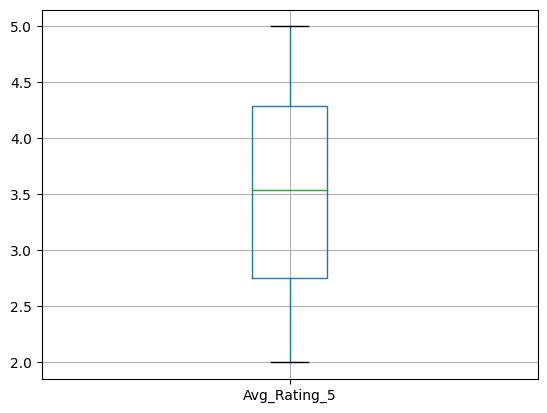

In [27]:
largeGames.boxplot(['Avg_Rating_5'])

<Axes: title={'center': 'Avg_Rating_5'}, xlabel='Genre'>

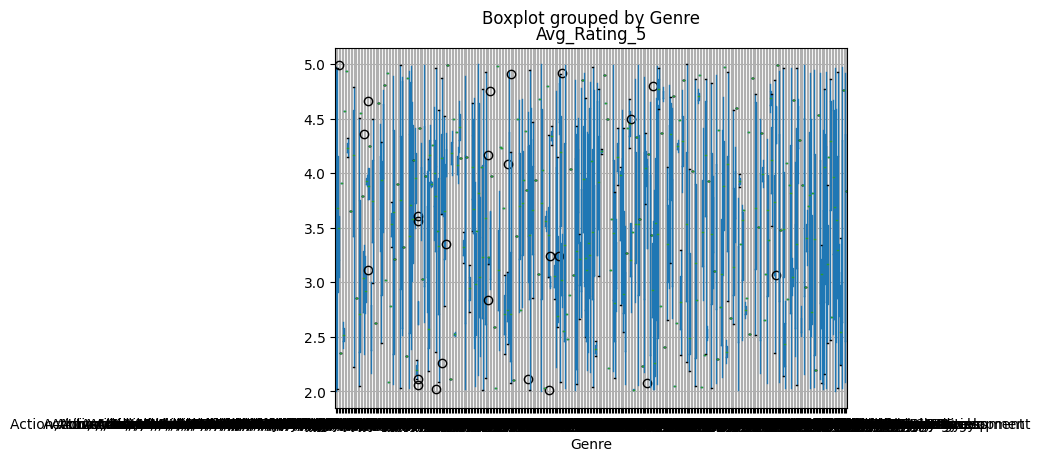

In [31]:
largeGames.boxplot(column='Avg_Rating_5',by='Genre')